## Data Call

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import t

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

import random
import time

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import plot_tree


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
df = pd.read_csv("C:/Users/User/Documents/Earthquake_Damage.csv")

In [3]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


## 사전 작업 사항

### [1] 입력 변수의 속성이 numeric 이 아닌 변수들에 대해 1-of-C coding (1-hot encoding) 방식을 통해 명목형(요인형) 변수를 범주의 개수만큼의 이진형(binary) 변수들로 구성되는 dummy variable을 생성하시오.

In [4]:
df.drop('building_id', axis=1, inplace=True)

In [5]:
df = pd.get_dummies(df)

### [2] 전체 데이터셋을 임의로 150,000 개의 빌딩이 포함된 Training dataset 과 50,000 개의 Validation dataset, 그리고 60,601 개의 Test dataset 으로 구분한 뒤 다음 각 물음에 답하시오. 분류 성능을 평가/비교할 때는 3-class classification 의 Accuracy 와 Balanced Correction Rate (BCR)을 이용하시오.

In [6]:
# Separate the features and target variable
X = df.drop('damage_grade', axis=1)
y = df['damage_grade']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=110601, stratify=y, random_state=2023)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=60601, stratify=y_temp, random_state=2023)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

In [7]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

150000
50000
60601


### 성능평가 함수

In [8]:
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bcr = balanced_accuracy_score(y_true, y_pred)
    return acc, bcr

#Q1.

##Multinomial logistic regression

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [ ]:
# Train과 Validation data set을 합하여 학습 진행
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the logistic regression classifier
logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logreg.fit(X_train_val, y_train_val)

y_pred = logreg.predict(X_test)
acc, bcr = evaluate(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("BCR:", bcr)
print("Confusion Matrix: ")
print(cm)

Accuracy: 0.5815580600980181
BCR: 0.4157814123264798
Confusion Matrix: 
[[ 1339  4450    54]
 [  977 32191  1308]
 [   70 18499  1713]]


##Classification and Regression Tree (CART)

## Pre-pruning 하이퍼파라미터 튜닝

In [10]:
# Define the decision tree classifier
tree = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 30, 100],
    'min_samples_leaf': [20, 40]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(tree, param_grid, scoring='balanced_accuracy', cv=3, refit=True)
grid_search.fit(X_train, y_train)

# Save the results of each grid search
results = []
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    tree = DecisionTreeClassifier(**params)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_val)
    acc, bcr = evaluate(y_val, y_pred)
    results.append((params, acc, bcr))

# Sort the results in descending order based on bcr
results.sort(key=lambda x: x[2], reverse=True)

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Parameters', 'ACC', 'BCR'])

# Display the results
print("Results (sorted by BCR):")
print(df_results)

# Get the best parameters and evaluate the performance
best_params = grid_search.best_params_
tree_best = DecisionTreeClassifier(**best_params)
tree_best.fit(X_train_val, y_train_val)

y_pred = tree_best.predict(X_test)
acc, bcr = evaluate(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)\

# Print the performance metrics
print("\nBest Parameters:", best_params)
print("Accuracy:", acc)
print("BCR:", bcr)
print("Confusion Matrix: ")
print(cm)

Results (sorted by BCR):
                                           Parameters      ACC       BCR
0   {'max_depth': 30, 'min_samples_leaf': 20, 'min...  0.70800  0.624807
1   {'max_depth': 30, 'min_samples_leaf': 20, 'min...  0.70794  0.624764
2   {'max_depth': 20, 'min_samples_leaf': 20, 'min...  0.70562  0.624283
3   {'max_depth': 20, 'min_samples_leaf': 20, 'min...  0.70556  0.624149
4   {'max_depth': 30, 'min_samples_leaf': 40, 'min...  0.71386  0.623531
5   {'max_depth': 30, 'min_samples_leaf': 40, 'min...  0.71380  0.623430
6   {'max_depth': 30, 'min_samples_leaf': 20, 'min...  0.71220  0.622993
7   {'max_depth': 20, 'min_samples_leaf': 20, 'min...  0.70978  0.622544
8   {'max_depth': 20, 'min_samples_leaf': 40, 'min...  0.71138  0.621758
9   {'max_depth': 20, 'min_samples_leaf': 40, 'min...  0.71128  0.621617
10  {'max_depth': 30, 'min_samples_leaf': 40, 'min...  0.71348  0.618139
11  {'max_depth': 20, 'min_samples_leaf': 40, 'min...  0.71120  0.616664
12  {'max_depth': 10, 'min

##ANN

###K-fold로 노드 설정

In [ ]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

# Find the best number of hidden nodes in terms of AUROC
# Candidate hidden nodes
hidden = np.arange(5, 51, 5)

# 3-fold cross-validation index
kf = KFold(n_splits=3)
val_perf = pd.DataFrame(columns=['hidden', 'ACC', 'BCR'])

for i, hidden_nodes in enumerate(hidden):
    print(f"Training ANN: the number of hidden nodes: {hidden_nodes}")
    eval_fold = []

    for train_index, val_index in kf.split(X_train):
        # Training with the data in (k-1) folds
        tmp_trn_input = X_train.iloc[train_index]
        tmp_trn_target = y_train.iloc[train_index]
        tmp_net = MLPClassifier(hidden_layer_sizes=(hidden_nodes,), max_iter=100, verbose=True)
        tmp_net.fit(tmp_trn_input, tmp_trn_target)

        # Evaluate the model with the remaining 1 fold
        tmp_val_input = X_train.iloc[val_index]
        tmp_val_target = y_train.iloc[val_index]

        eval_fold.append(confusion_matrix(tmp_val_target, tmp_net.predict(tmp_val_input)))

    # Confusion matrix
    cm = np.mean(eval_fold, axis=0).astype(float)
    # Simple Accuracy
    ACC = np.trace(cm) / np.sum(cm)
    # Balanced Correction Rate
    BCR = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    # Append the values to the DataFrame
    val_perf = val_perf.append({'hidden': int(hidden_nodes), 'ACC': float(ACC), 'BCR': float(BCR)}, ignore_index=True)

# Sort based on BCR in descending order
ordered_val_perf = val_perf.sort_values(by='BCR', ascending=False)

# Print the ordered results with hidden nodes
print("Ordered Results based on BCR:")
print(ordered_val_perf[['hidden', 'ACC', 'BCR']])

Training ANN: the number of hidden nodes: 5
Iteration 1, loss = 18.57734881
Iteration 2, loss = 17.04745343
Iteration 3, loss = 17.04276595
Iteration 4, loss = 16.84018945
Iteration 5, loss = 16.80871920
Iteration 6, loss = 16.61970669
Iteration 7, loss = 16.87419018
Iteration 8, loss = 16.52312341
Iteration 9, loss = 16.22738700
Iteration 10, loss = 16.32325025
Iteration 11, loss = 16.17939788
Iteration 12, loss = 16.00756596
Iteration 13, loss = 16.01561434
Iteration 14, loss = 16.31487799
Iteration 15, loss = 16.26531683
Iteration 16, loss = 15.71260889
Iteration 17, loss = 15.56584613
Iteration 18, loss = 15.46569038
Iteration 19, loss = 16.48884030
Iteration 20, loss = 15.13430424
Iteration 21, loss = 15.80272607
Iteration 22, loss = 15.99074054
Iteration 23, loss = 15.71254335
Iteration 24, loss = 15.84126786
Iteration 25, loss = 15.47143023
Iteration 26, loss = 16.09793259
Iteration 27, loss = 15.49873658
Iteration 28, loss = 16.05548008
Iteration 29, loss = 15.19696424
Iteratio

In [ ]:
ordered_val_perf

,hidden,ACC,BCR
2,15.0,0.442427,0.431740
6,35.0,0.505720,0.401430
1,10.0,0.523440,0.401210
7,40.0,0.433433,0.395161
0,5.0,0.417760,0.391791
8,45.0,0.425953,0.365546
3,20.0,0.497833,0.358999
4,25.0,0.567740,0.346714
9,50.0,0.499507,0.343014
5,30.0,0.493493,0.341156


##ANN 하이퍼파라미터 튜닝

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the hyperparameter values
learning_rates = [0.01, 0.05, 0.1]
num_hidden_layers = [3, 5, 7]
num_hidden_nodes = [15, 25, 35]

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['learning_rate', 'hidden_layers', 'hidden_nodes', 'ACC', 'BCR'])

# Iterate over all combinations of hyperparameters
for lr in learning_rates:
    for num_layers in num_hidden_layers:
        for num_nodes in num_hidden_nodes:
            # Initialize the ANN model with current hyperparameters
            model = MLPClassifier(
                hidden_layer_sizes=(num_nodes,) * num_layers,
                learning_rate_init=lr,
                max_iter=50,
                batch_size=32,
                random_state=2023
            )

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions on the validation set
            y_pred = model.predict(X_val)

            # Calculate evaluation metrics
            acc = accuracy_score(y_val, y_pred)
            bcr = balanced_accuracy_score(y_val, y_pred)

            # Append the results to the DataFrame
            results_df = results_df.append({
                'learning_rate': lr,
                'hidden_layers': num_layers,
                'hidden_nodes': num_nodes,
                'ACC': acc,
                'BCR': bcr
            }, ignore_index=True)

# Sort the results DataFrame by BCR in descending order
results_df_sorted = results_df.sort_values(by='BCR', ascending=False)

# Print the sorted results DataFrame
print("\nSorted Results DataFrame:")
results_df_sorted

# Retrieve the optimal hyperparameters from the first row
optimal_lr = results_df_sorted.iloc[0]['learning_rate']
optimal_layers = results_df_sorted.iloc[0]['hidden_layers']
optimal_nodes = results_df_sorted.iloc[0]['hidden_nodes']

# Print the optimal hyperparameters
print("\nOptimal Hyperparameters:")
print(f"Learning Rate: {optimal_lr}")
print(f"Number of Hidden Layers: {optimal_layers}")
print(f"Number of Hidden Nodes: {optimal_nodes}")


Sorted Results DataFrame:
    learning_rate  hidden_layers  hidden_nodes      ACC       BCR
3            0.01            5.0          15.0  0.64090  0.578886
1            0.01            3.0          25.0  0.66120  0.578572
4            0.01            5.0          25.0  0.65128  0.568166
8            0.01            7.0          35.0  0.64054  0.562641
5            0.01            5.0          35.0  0.66092  0.538963
6            0.01            7.0          15.0  0.65476  0.538767
0            0.01            3.0          15.0  0.64910  0.488787
7            0.01            7.0          25.0  0.64992  0.487113
2            0.01            3.0          35.0  0.64910  0.439936
18           0.10            3.0          15.0  0.56892  0.333333
25           0.10            7.0          25.0  0.56892  0.333333
24           0.10            7.0          15.0  0.56892  0.333333
23           0.10            5.0          35.0  0.56892  0.333333
22           0.10            5.0          25.0  0

In [ ]:
# Create the new model with the optimal hyperparameters
optimal_model = MLPClassifier(
    hidden_layer_sizes=(15,) * 5,
    learning_rate_init=0.01,
    max_iter=10,
    random_state=2023
)

# Train the optimal model using the combined training and validation sets
optimal_model.fit(X_train_val, y_train_val)

# Make predictions on the test set using the optimal model
y_pred = optimal_model.predict(X_test)

# Calculate evaluation metrics for the optimal model
acc = accuracy_score(y_test, y_pred)
bcr = balanced_accuracy_score(y_test, y_pred)

# Print the optimal performance
print("\nOptimal Performance:")
print(f"ACC: {acc}")
print(f"BCR: {bcr}")
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

#Q2.

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Initialize the lists to store bootstraps, BCR scores, ACC scores, and feature importances
results = []
acc_scores_bagging_cart = []
bcr_scores_bagging_cart = []
feature_importances_bagging_cart = []

# Define the range of bootstrap iterations
bootstrap_range = range(30, 301, 30)

# Iterate over different numbers of bootstraps
for n_bootstraps in bootstrap_range:
    # Create the base decision tree classifier
    base_model = DecisionTreeClassifier(max_depth=30, min_samples_leaf=20, min_samples_split=30)

    # Create the bagging classifier with the specified number of bootstraps
    bagging_cart_model = BaggingClassifier(base_estimator=base_model, n_estimators=n_bootstraps, n_jobs=2, bootstrap=True, random_state=2023, oob_score=True)

    # Fit the model on the training data
    bagging_cart_model.fit(X_train, y_train)

    y_pred = bagging_cart_model.predict(X_val)
    acc, bcr = evaluate(y_val, y_pred)

    acc_scores_bagging_cart.append(acc)
    bcr_scores_bagging_cart.append(bcr)

    # Store the parameters, accuracy score, and feature importances
    results.append({
        'Bootstraps': n_bootstraps,
        'BCR': bcr,
        'ACC': acc})

    feature_importances_bagging_cart.append(bagging_cart_model.estimators_[0].feature_importances_)


# Create a DataFrame from the results
df_results_bagging_cart = pd.DataFrame(results)

# Sort the DataFrame by accuracy score in descending order
df_results_bagging_cart = df_results_bagging_cart.sort_values(by='BCR', ascending=False)
# Print the sorted results
df_results_bagging_cart

   Bootstraps       BCR       ACC
0          30  0.639746  0.736902
1          60  0.639397  0.737843
2          90  0.639023  0.737414
5         180  0.638273  0.737265
6         210  0.637833  0.737381
8         270  0.637799  0.737265
7         240  0.637795  0.737199
9         300  0.637715  0.737480
3         120  0.637634  0.737364
4         150  0.637230  0.736836
Optimal number of bootstraps for Bagging (CART): 30
Confusion Matrix:
[[ 2603  3173    67]
 [ 1032 29544  3900]
 [   90  7682 12510]]


In [ ]:
optimal_bootstraps_bagging_cart = int(df_results_bagging_cart.iloc[0]['Bootstraps'])
print("Optimal number of bootstraps for Bagging (CART):", optimal_bootstraps_bagging_cart)


# Calculate and print the confusion matrix for the optimal number of bootstraps
base_model = DecisionTreeClassifier(max_depth=30, min_samples_leaf=20, min_samples_split=30)
optimal_bagging_cart_model = BaggingClassifier(base_estimator=base_model, n_estimators=optimal_bootstraps_bagging_cart, n_jobs=-1, bootstrap=True, random_state=2023, oob_score=True)
optimal_bagging_cart_model.fit(X_train_val, y_train_val)
y_pred = optimal_bagging_cart_model.predict(X_test)
acc, bcr = evaluate(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy Score", acc)
print("BCR score", bcr)
print("Confusion Matrix:")
print(confusion_mat)

#Q3.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Initialize the lists to store bootstraps, BCR scores, and ACC scores
results = []
acc_scores_bagging = []
bcr_scores_bagging = []
feature_importances_list_bagging = []

# Define the range of bootstrap iterations
bootstrap_range = range(30, 301, 30)

# Iterate over different numbers of bootstraps
for n_bootstraps in bootstrap_range:
    # Create the base random forest classifier
    base_model = RandomForestClassifier(n_estimators=3, verbose=1, random_state=2023)

    # Create the bagging classifier with the specified number of bootstraps
    bagging_model = BaggingClassifier(base_estimator=base_model, n_estimators=n_bootstraps, n_jobs=-1, bootstrap=True, random_state=2023, oob_score=True)

    # Fit the model on the training data
    bagging_model.fit(X_train, y_train)

    y_pred = bagging_model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    bcr = balanced_accuracy_score(y_val, y_pred)

    acc_scores_bagging.append(acc)
    bcr_scores_bagging.append(bcr)

    # Store the parameters and accuracy score
    results.append({
        'Bootstraps': n_bootstraps,
        'BCR': bcr,
        'ACC': acc})

    print(results)

    # Calculate feature importances
    feature_importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)
    feature_importances_list_bagging.append(feature_importances)

# Create a DataFrame from the results
df_results_bagging = pd.DataFrame(results)

# Sort the DataFrame by accuracy score in descending order
df_results_bagging = df_results_bagging.sort_values(by='BCR', ascending=False)
df_results_bagging

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[{'Bootstraps': 30, 'BCR': 0.6154555063245389, 'ACC': 0.7116}]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[{'Bootstraps': 30, 'BCR': 0.6154555063245389, 'ACC': 0.7116}, {'Bootstraps': 60, 'BCR': 0.6146553251558267, 'ACC': 0.71382}]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[{'Bootstraps': 30, 'BCR': 0.6154555063245389, 'ACC': 0.7116}, {'Bootstraps': 60, 'BCR': 0.6146553251558267, 'ACC': 0.71382}, {'Bootstraps': 90, 'BCR': 0.6148554530680759, 'ACC': 0.71482}]


In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix


# Get the optimal number of bootstraps
#optimal_bootstraps_bagging = int(df_results_bagging.iloc[0]['Bootstraps'])

# Print the optimal number of bootstraps
#print("Optimal number of bootstraps for Bagging (Random Forest):", optimal_bootstraps_bagging)

# Calculate and print the confusion matrix for the optimal number of bootstraps
base_model = RandomForestClassifier(n_estimators=3, verbose=1, random_state=2023)
optimal_bagging_model = BaggingClassifier(base_estimator=base_model, n_estimators=300, n_jobs=2, bootstrap=True, random_state=2023)
optimal_bagging_model.fit(X_train_val, y_train_val)
y_pred = optimal_bagging_model.predict(X_test)
acc, bcr = evaluate(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy Score", acc)
print("BCR score", bcr)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy Score 0.7145921684460652
BCR score 0.619399604176898
Confusion Matrix:
[[ 2574  3146   123]
 [ 1169 29093  4214]
 [  113  8531 11638]]


In [ ]:
# Fit the base estimator
optimal_bagging_model.base_estimator_.fit(X_train_val, y_train_val)

# Get the feature names
feature_names = X.columns

# Get the variable importance from the base estimator
var_imp = optimal_bagging_model.base_estimator_.feature_importances_

# Create a DataFrame to store the variable importance
var_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': var_imp})

# Sort the DataFrame by importance in descending order
var_imp_df = var_imp_df.sort_values('Importance', ascending=False)

# Print the variable importance DataFrame
print("Variable Importance:")
var_imp_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Variable Importance:


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


,Feature,Importance
2,geo_level_3_id,0.153423
1,geo_level_2_id,0.136616
0,geo_level_1_id,0.134061
4,age,0.125759
5,area_percentage,0.112587
...,...,...
26,has_secondary_use_health_post,0.000048
28,has_secondary_use_use_police,0.000048
27,has_secondary_use_gov_office,0.000030
59,plan_configuration_n,0.000022


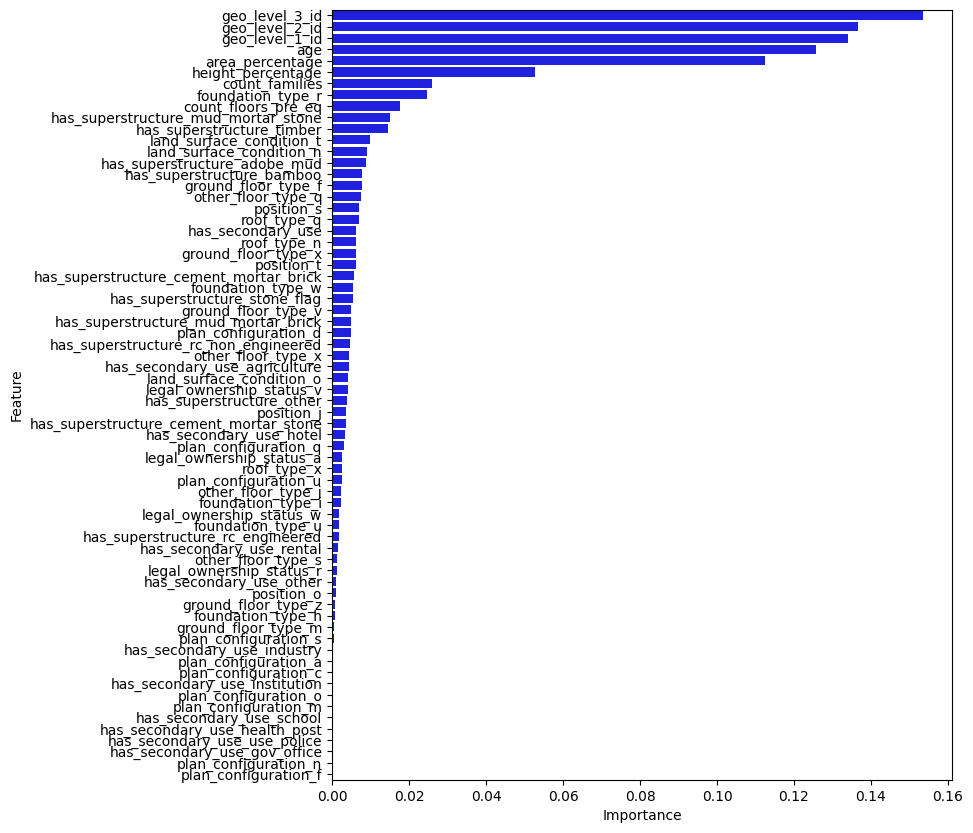

In [ ]:
plt.figure(figsize=(8,10))
sns.barplot(
    x='Importance',
    y='Feature',
    color='blue',
    data=var_imp_df
)
plt.show()

##CART

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the feature importances list to a NumPy array
feature_importances_bagging_cart = np.array(feature_importances_bagging_cart)

# Get the feature names from the DataFrame columns
feature_names = X.columns

# Calculate the number of rows and columns for subplot arrangement
num_plots = feature_importances_bagging_cart.shape[0]
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 24))

# Iterate over each bootstrap and create separate plots
for i, ax in enumerate(axes.flat):
    # Check if the current subplot is beyond the number of bootstraps
    if i >= num_plots:
        break

    # Sort the feature importances for the current bootstrap iteration
    sorted_indices = np.argsort(feature_importances_bagging_cart[i])[::-1]
    sorted_importances = feature_importances_bagging_cart[i][sorted_indices]

    # Plot the sorted feature importances
    ax.plot(range(len(sorted_importances)), sorted_importances)

    # Set the x-axis labels to variable names based on the sorted indices
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=45, fontsize=7)

    # Set the y-axis label
    ax.set_ylabel('Feature Importance')

    # Set the title
    ax.set_title(f'Feature Importance for Bootstrap {bootstrap_range[i]} (Bagging CART)', fontsize=10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot the ACC and BCR of CART
plt.figure(figsize=(10, 6))
plt.scatter(df_results_bagging_cart['Bootstraps'], df_results_bagging_cart['ACC'], label='CART ACC', marker='o')
plt.scatter(df_results_bagging_cart['Bootstraps'], df_results_bagging_cart['BCR'], label='CART BCR', marker='x')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Performance')
plt.title('Performance Comparison - CART')
plt.legend()
plt.grid(True)
plt.show()

##RF

In [ ]:
# Convert the feature importances list to a NumPy array
feature_importances_bagging = np.array(feature_importances_list_bagging)

# Get the feature names from the DataFrame columns
feature_names = X.columns

# Calculate the number of rows and columns for subplot arrangement
num_plots = feature_importances_bagging.shape[0]
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 24))

# Iterate over each bootstrap and create separate plots
for i, ax in enumerate(axes.flat):
    # Check if the current subplot is beyond the number of bootstraps
    if i >= num_plots:
        break

    # Sort the feature importances for the current bootstrap iteration
    sorted_indices = np.argsort(feature_importances_bagging[i])[::-1]
    sorted_importances = feature_importances_bagging[i][sorted_indices]

    # Plot the sorted feature importances
    ax.plot(range(len(sorted_importances)), sorted_importances)

    # Set the x-axis labels to variable names based on the sorted indices
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=45, fontsize=7)

    # Set the y-axis label
    ax.set_ylabel('Feature Importance')

    # Set the title
    ax.set_title(f'Feature Importance for Bootstrap {bootstrap_range[i]} (Bagging Random Forest)', fontsize=10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


NameError: ignored

In [ ]:
# Plot the ACC and BCR of Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(df_results_bagging['Bootstraps'], df_results_bagging['ACC'], label='RF ACC', marker='o')
plt.scatter(df_results_bagging['Bootstraps'], df_results_bagging['BCR'], label='RF BCR', marker='x')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Performance')
plt.title('Performance Comparison - Random Forest')
plt.legend()
plt.grid(True)
plt.show()


NameError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot the OOB error for Code 2 (Random Forest)
plt.figure(figsize=(10, 6))
plt.plot(bootstrap_range, oob_errors_bagging)
plt.xlabel('Number of Bootstraps')
plt.ylabel('OOB Error')
plt.title('OOB Error - (Bagging with Random Forest)')
plt.grid(True)
plt.show()


#Q4.

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize lists to store accuracy and BCR scores
acc_scores = []
bcr_scores = []

# Set the number of iterations
n_iterations = 30

for i in range(n_iterations):
    # Define the baselearner model with random state
    baselearner = MLPClassifier(hidden_layer_sizes=(15,5), learning_rate_init=0.01, max_iter=10, random_state=i)

    # Fit the model on the training data
    baselearner.fit(X_train_val, y_train_val)

    y_pred = baselearner.predict(X_test)
    acc, bcr = evaluate(y_test, y_pred)

    # Store accuracy and BCR scores
    acc_scores.append(acc)
    bcr_scores.append(bcr)

# Calculate mean and standard deviation of accuracy and BCR scores
acc_mean = np.mean(acc_scores)
bcr_mean = np.mean(bcr_scores)
acc_std = np.std(acc_scores)
bcr_std = np.std(bcr_scores)

# Print the results
print("Accuracy Mean:", acc_mean)
print("Accuracy Std:", acc_std)
print("BCR Mean:", bcr_mean)
print("BCR Std:", bcr_std)


Accuracy Mean: 0.6355109651655914
Accuracy Std: 0.004666677184404536
BCR Mean: 0.5203929538334827
BCR Std: 0.02139815916563126


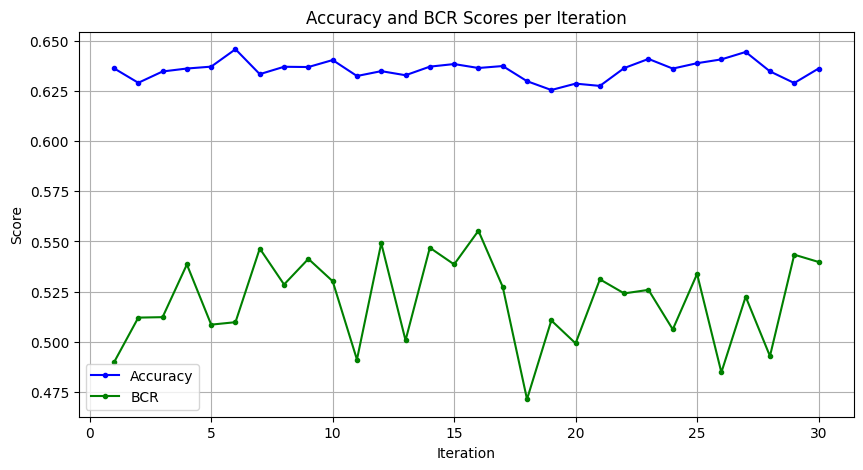

In [ ]:
# Plot accuracy and BCR scores for each iteration
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_iterations + 1), acc_scores, 'b.-', label='Accuracy')
plt.plot(range(1, n_iterations + 1), bcr_scores, 'g.-', label='BCR')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Accuracy and BCR Scores per Iteration')
plt.legend()
plt.grid(True)
plt.show()

#Q5.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# Initialize lists to store accuracy and BCR scores
results = []

# Set the range of bootstrap iterations
bootstrap_range = range(30, 301, 30)

# Set the number of iterations
n_iterations = 10

# Initialize variables to track the optimal values
optimal_bootstrap = None
optimal_mean_accuracy = -1
optimal_mean_bcr = -1

for bootstrap in bootstrap_range:
    acc_scores = []
    bcr_scores = []

    for i in range(n_iterations):
        baselearner = MLPClassifier(learning_rate_init=0.01, hidden_layer_sizes=(15,5), solver='lbfgs', tol=1e-2, random_state=i, early_stopping=True)
        bagging_model = BaggingClassifier(base_estimator=baselearner, n_estimators=bootstrap, n_jobs=2, bootstrap=True, random_state=2023)
        bagging_model.fit(X_train, y_train)

        y_pred = bagging_model.predict(X_val)
        acc, bcr = evaluate(y_val, y_pred)

        # Store accuracy and BCR scores
        acc_scores.append(acc)
        bcr_scores.append(bcr)

    # Calculate mean and standard deviation of accuracy and BCR scores
    acc_mean = np.mean(acc_scores)
    bcr_mean = np.mean(bcr_scores)
    acc_std = np.std(acc_scores)
    bcr_std = np.std(bcr_scores)

    # Store the results in a dictionary
    result = {
        'Bootstrap': bootstrap,
        'Accuracy Mean': acc_mean,
        'Accuracy Std': acc_std,
        'BCR Mean': bcr_mean,
        'BCR Std': bcr_std
    }
    results.append(result)
    result

    # Check if the current mean accuracy is higher than the previous optimal value
    if acc_mean > optimal_mean_accuracy:
        optimal_mean_accuracy = acc_mean
        optimal_bootstrap = bootstrap

    # Check if the current mean BCR is higher than the previous optimal value
    if bcr_mean > optimal_mean_bcr:
        optimal_mean_bcr = bcr_mean
        optimal_bootstrap = bootstrap

# Print the results
df_results = pd.DataFrame(results)
df_results

KeyboardInterrupt: ignored

In [ ]:
# Print the optimal Bootstrap count
print("Optimal Bootstrap Count:", optimal_bootstrap)

# Create the optimal baselearner model for the optimal bootstrap count
optimal_baselearner = MLPClassifier(learning_rate_init=0.01, hidden_layer_sizes=(15,5), solver='lbfgs', tol=1e-2, random_state=2023, early_stopping=True)

# Create the bagging model with the optimal baselearner and bootstrap count
optimal_bagging_model = BaggingClassifier(base_estimator=optimal_baselearner, n_estimators=optimal_bootstrap, n_jobs=2, bootstrap=True, random_state=2023)

# Fit the optimal bagging model on the training and validation set
optimal_bagging_model.fit(X_train_val, y_train_val)

# Predict on the test set
y_pred = optimal_bagging_model.predict(X_test)
# Calculate accuracy and BCR scores on the test data
test_acc_score = accuracy_score(y_test, y_pred)
test_bcr_score = balanced_accuracy_score(y_test, y_pred)

# Compare the performance with other models
print("Performance on Test Data:")
print("Accuracy Score:", test_acc_score)
print("BCR Score:", test_bcr_score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix for Optimal Bootstrap Count:")
print(cm)

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and BCR scores for each iteration
plt.figure(figsize=(10, 5))
plt.errorbar(df_results['Bootstrap'], df_results['Accuracy Mean'], yerr=df_results['Accuracy Std'], fmt='b.-', label='Accuracy')
plt.errorbar(df_results['Bootstrap'], df_results['BCR Mean'], yerr=df_results['BCR Std'], fmt='g.-', label='BCR')
plt.xlabel('Bootstrap')
plt.ylabel('Mean Score')
plt.title('Mean Accuracy and BCR Scores per Bootstrap with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

#Q6.

In [9]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Define the parameter combinations
param_combinations = [
    {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 20},

]

# Create lists to store results
results = []
bcr_scores = []
acc_scores = []

# Iterate over parameter combinations
for params in param_combinations:
    # Create the base estimator
    base_estimator = DecisionTreeClassifier(**params)

    # Create the AdaBoost model
    adaboost_model = AdaBoostClassifier(
        base_estimator=base_estimator,
        random_state=2023
    )

    # Train the model
    adaboost_model.fit(X_train, y_train)

    # Predict on validation data
    y_pred_val = adaboost_model.predict(X_val)

    # Calculate accuracy and BCR scores
    acc_score = accuracy_score(y_val, y_pred_val)
    bcr_score = balanced_accuracy_score(y_val, y_pred_val)

    # Store the results
    results.append(params)
    bcr_scores.append(bcr_score)
    acc_scores.append(acc_score)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Parameter Settings': results, 'BCR Score': bcr_scores, 'Accuracy Score': acc_scores})

# Sort the results by BCR score in descending order
sorted_results = results_df.sort_values('BCR Score', ascending=False)

# Select the best parameter combination based on BCR score
best_params = sorted_results.iloc[0]['Parameter Settings']
best_score = sorted_results.iloc[0]['BCR Score']
best_acc = sorted_results.iloc[0]['Accuracy Score']

# Print the best parameter combination and score
print("Best Parameter Combination:", best_params)
print("Best BCR Score:", best_score)
print("Best Accuracy Score:", best_acc)
sorted_results

Best Parameter Combination: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 20}
Best BCR Score: 0.6121296392211527
Best Accuracy Score: 0.6795


,Parameter Settings,BCR Score,Accuracy Score
0,"{'max_depth': 5, 'min_samples_split': 10, 'min...",0.61213,0.6795


In [10]:
best_params

{'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 20}

In [11]:
# Parse and extract optimal hyperparameter values
best_params = sorted_results.iloc[0]['Parameter Settings']
best_params_str = str(best_params)
print("best_params_str:", best_params_str)
max_depth = int(best_params_str.split(',')[0].split(':')[1].strip())
min_samples_split = int(best_params_str.split(',')[1].split(':')[1].strip())
min_samples_leaf = int(best_params_str.split(',')[2].split(':')[1].strip().rstrip('}'))  # Remove the closing curly brace

# Train AdaBoost model using optimal hyperparameter values
best_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    ),
    random_state=2023
)
best_model.fit(X_train_val, y_train_val)

# Test dataset prediction
y_pred = best_model.predict(X_test)

# Evaluate classification performance
accuracy = accuracy_score(y_test, y_pred)
bcr = balanced_accuracy_score(y_test, y_pred)

# Output the results
print("Accuracy:", accuracy)
print("BCR:", bcr)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

best_params_str: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 20}
Accuracy: 0.6851372089569479
BCR: 0.6164430057812612


array([[ 2867,  2898,    78],
       [ 1975, 26953,  5548],
       [  160,  8422, 11700]], dtype=int64)

#Q7.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score

param_combinations = [
    {'n_estimators': 1, 'subsample': 0.5, 'loss': 'deviance'},

]

# Create lists to store results
results = []
bcr_scores = []
acc_scores = []

# Iterate over parameter combinations
for params in param_combinations:
    gbm_model = GradientBoostingClassifier(random_state=2023, learning_rate=0.1, **params)

    # Train the model
    gbm_model.fit(X_train, y_train)

    # Predict on validation data
    y_pred_val = gbm_model.predict(X_val)

    # Calculate accuracy and BCR scores
    acc_score = accuracy_score(y_val, y_pred_val)
    bcr_score = balanced_accuracy_score(y_val, y_pred_val)

    # Store the results
    results.append(params)
    bcr_scores.append(bcr_score)
    acc_scores.append(acc_score)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Parameter Settings': results, 'BCR Score': bcr_scores, 'Accuracy Score': acc_scores})

# Sort the results DataFrame by BCR score in descending order
results_df.sort_values(by='BCR Score', ascending=False, inplace=True)
results_df

,Parameter Settings,BCR Score,Accuracy Score
0,"{'n_estimators': 1, 'subsample': 0.5, 'loss': ...",0.333333,0.56892


In [14]:
# Get the best parameters from the first row of the sorted DataFrame
best_params = results_df.iloc[0]['Parameter Settings']

# Train the GBM model with the best parameters on the entire training set
best_gbm_model = GradientBoostingClassifier(random_state=2023, **best_params)
best_gbm_model.fit(X_train_val, y_train_val)

# Predict on the test data using the best model
y_pred = best_gbm_model.predict(X_test)

# Calculate accuracy and BCR scores on the test data
test_acc_score = accuracy_score(y_test, y_pred)
test_bcr_score = balanced_accuracy_score(y_test, y_pred)

# Compare the performance with other models
print("Performance on Test Data:")
print("Accuracy Score:", test_acc_score)
print("BCR Score:", test_bcr_score)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

Performance on Test Data:
Accuracy Score: 0.5689015032755235
BCR Score: 0.3333333333333333


array([[    0,  5843,     0],
       [    0, 34476,     0],
       [    0, 20282,     0]], dtype=int64)

In [15]:
feature_names = X.columns
# Variable Importance
var_imp = best_gbm_model.feature_importances_
var_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': var_imp})
var_imp_df = var_imp_df.sort_values('Importance', ascending=False)
var_imp_df

,Feature,Importance
0,geo_level_1_id,0.467608
35,foundation_type_r,0.363462
34,foundation_type_i,0.065927
8,has_superstructure_mud_mortar_stone,0.046802
12,has_superstructure_cement_mortar_brick,0.019228
...,...,...
30,land_surface_condition_n,0.000000
31,land_surface_condition_o,0.000000
32,land_surface_condition_t,0.000000
36,foundation_type_u,0.000000


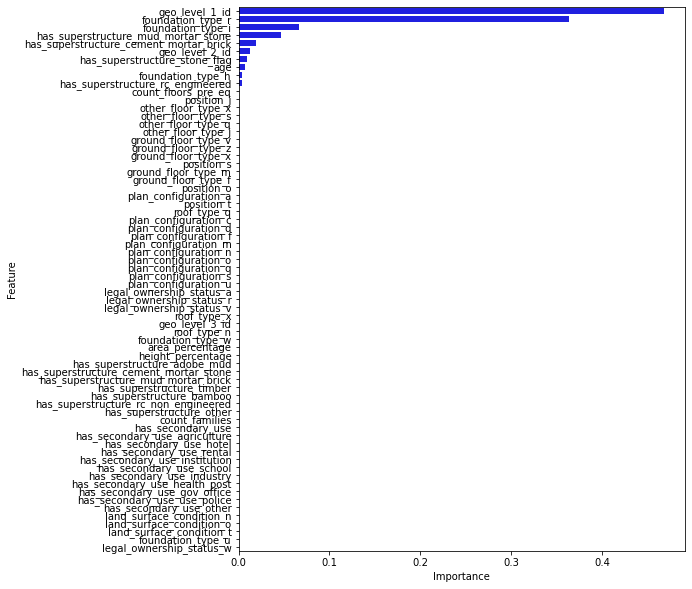

In [16]:
plt.figure(figsize=(8,10))
sns.barplot(
    x='Importance',
    y='Feature',
    color='blue',
    data=var_imp_df
)
plt.show()

#Q8.

#Extra Question

In [ ]:
len(df[df['damage_grade']==1])

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Separate data by categories
category_1 = df[df['damage_grade'] == 1]
category_2 = df[df['damage_grade'] == 2]
category_3 = df[df['damage_grade'] == 3]



# Downsample each category
downsampled_1 = resample(category_1, n_samples=25124, random_state=2023)
downsampled_2 = resample(category_2, n_samples=25124, random_state=2023)
downsampled_3 = resample(category_3, n_samples=25124, random_state=2023)

# Combine downsampled data
df = pd.concat([downsampled_1, downsampled_2, downsampled_3])

df = df.sample(frac=1, random_state=42)

df.reset_index(drop=True, inplace=True)


In [ ]:
len(df)

75372

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
X = df.drop('damage_grade', axis=1)
y = df['damage_grade']

# Split into train and remaining data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2023)

# Split remaining data into validation and test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=2023)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

45222
15075
15075


In [ ]:
from sklearn.ensemble import BaggingClassifier

# Initialize the lists to store bootstraps, BCR scores, ACC scores, and feature importances
results = []
acc_scores_bagging_cart = []
bcr_scores_bagging_cart = []
feature_importances_bagging_cart = []

# Define the range of bootstrap iterations
bootstrap_range = range(30, 301, 30)

# Iterate over different numbers of bootstraps
for n_bootstraps in bootstrap_range:
    # Create the base decision tree classifier
    base_model = DecisionTreeClassifier(max_depth=30, min_samples_leaf=20, min_samples_split=30)

    # Create the bagging classifier with the specified number of bootstraps
    bagging_cart_model = BaggingClassifier(base_estimator=base_model, n_estimators=n_bootstraps, n_jobs=2, bootstrap=True, random_state=2023, oob_score=True)

    # Fit the model on the training data
    bagging_cart_model.fit(X_train, y_train)

    y_pred = bagging_cart_model.predict(X_val)
    acc, bcr = evaluate(y_val, y_pred)

    acc_scores_bagging_cart.append(acc)
    bcr_scores_bagging_cart.append(bcr)

    # Store the parameters, accuracy score, and feature importances
    results.append({
        'Bootstraps': n_bootstraps,
        'BCR': bcr,
        'ACC': acc})

    feature_importances_bagging_cart.append(bagging_cart_model.estimators_[0].feature_importances_)


# Create a DataFrame from the results
df_results_bagging_cart = pd.DataFrame(results)

# Sort the DataFrame by accuracy score in descending order
df_results_bagging_cart = df_results_bagging_cart.sort_values(by='BCR', ascending=False)
# Print the sorted results
df_results_bagging_cart

,Bootstraps,BCR,ACC
2,90,0.713964,0.713964
9,300,0.713234,0.713234
8,270,0.713035,0.713035
1,60,0.712371,0.712371
4,150,0.712172,0.712172
5,180,0.712106,0.712106
3,120,0.712040,0.712040
6,210,0.711774,0.711774
7,240,0.711708,0.711708
0,30,0.710647,0.710647


In [ ]:
optimal_bootstraps_bagging_cart = int(df_results_bagging_cart.iloc[0]['Bootstraps'])
print("Optimal number of bootstraps for Bagging (CART):", optimal_bootstraps_bagging_cart)


# Calculate and print the confusion matrix for the optimal number of bootstraps
base_model = DecisionTreeClassifier(max_depth=30, min_samples_leaf=20, min_samples_split=30)
optimal_bagging_cart_model = BaggingClassifier(base_estimator=base_model, n_estimators=optimal_bootstraps_bagging_cart, n_jobs=-1, bootstrap=True, random_state=2023, oob_score=True)
optimal_bagging_cart_model.fit(X_train_val, y_train_val)
y_pred = optimal_bagging_cart_model.predict(X_test)
acc, bcr = evaluate(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy Score", acc)
print("BCR score", bcr)
print("Confusion Matrix:")
print(confusion_mat)

Optimal number of bootstraps for Bagging (CART): 90
Accuracy Score 0.7139635157545605
BCR score 0.7139635157545605
Confusion Matrix:
[[4190  726  109]
 [ 956 2942 1127]
 [ 230 1164 3631]]


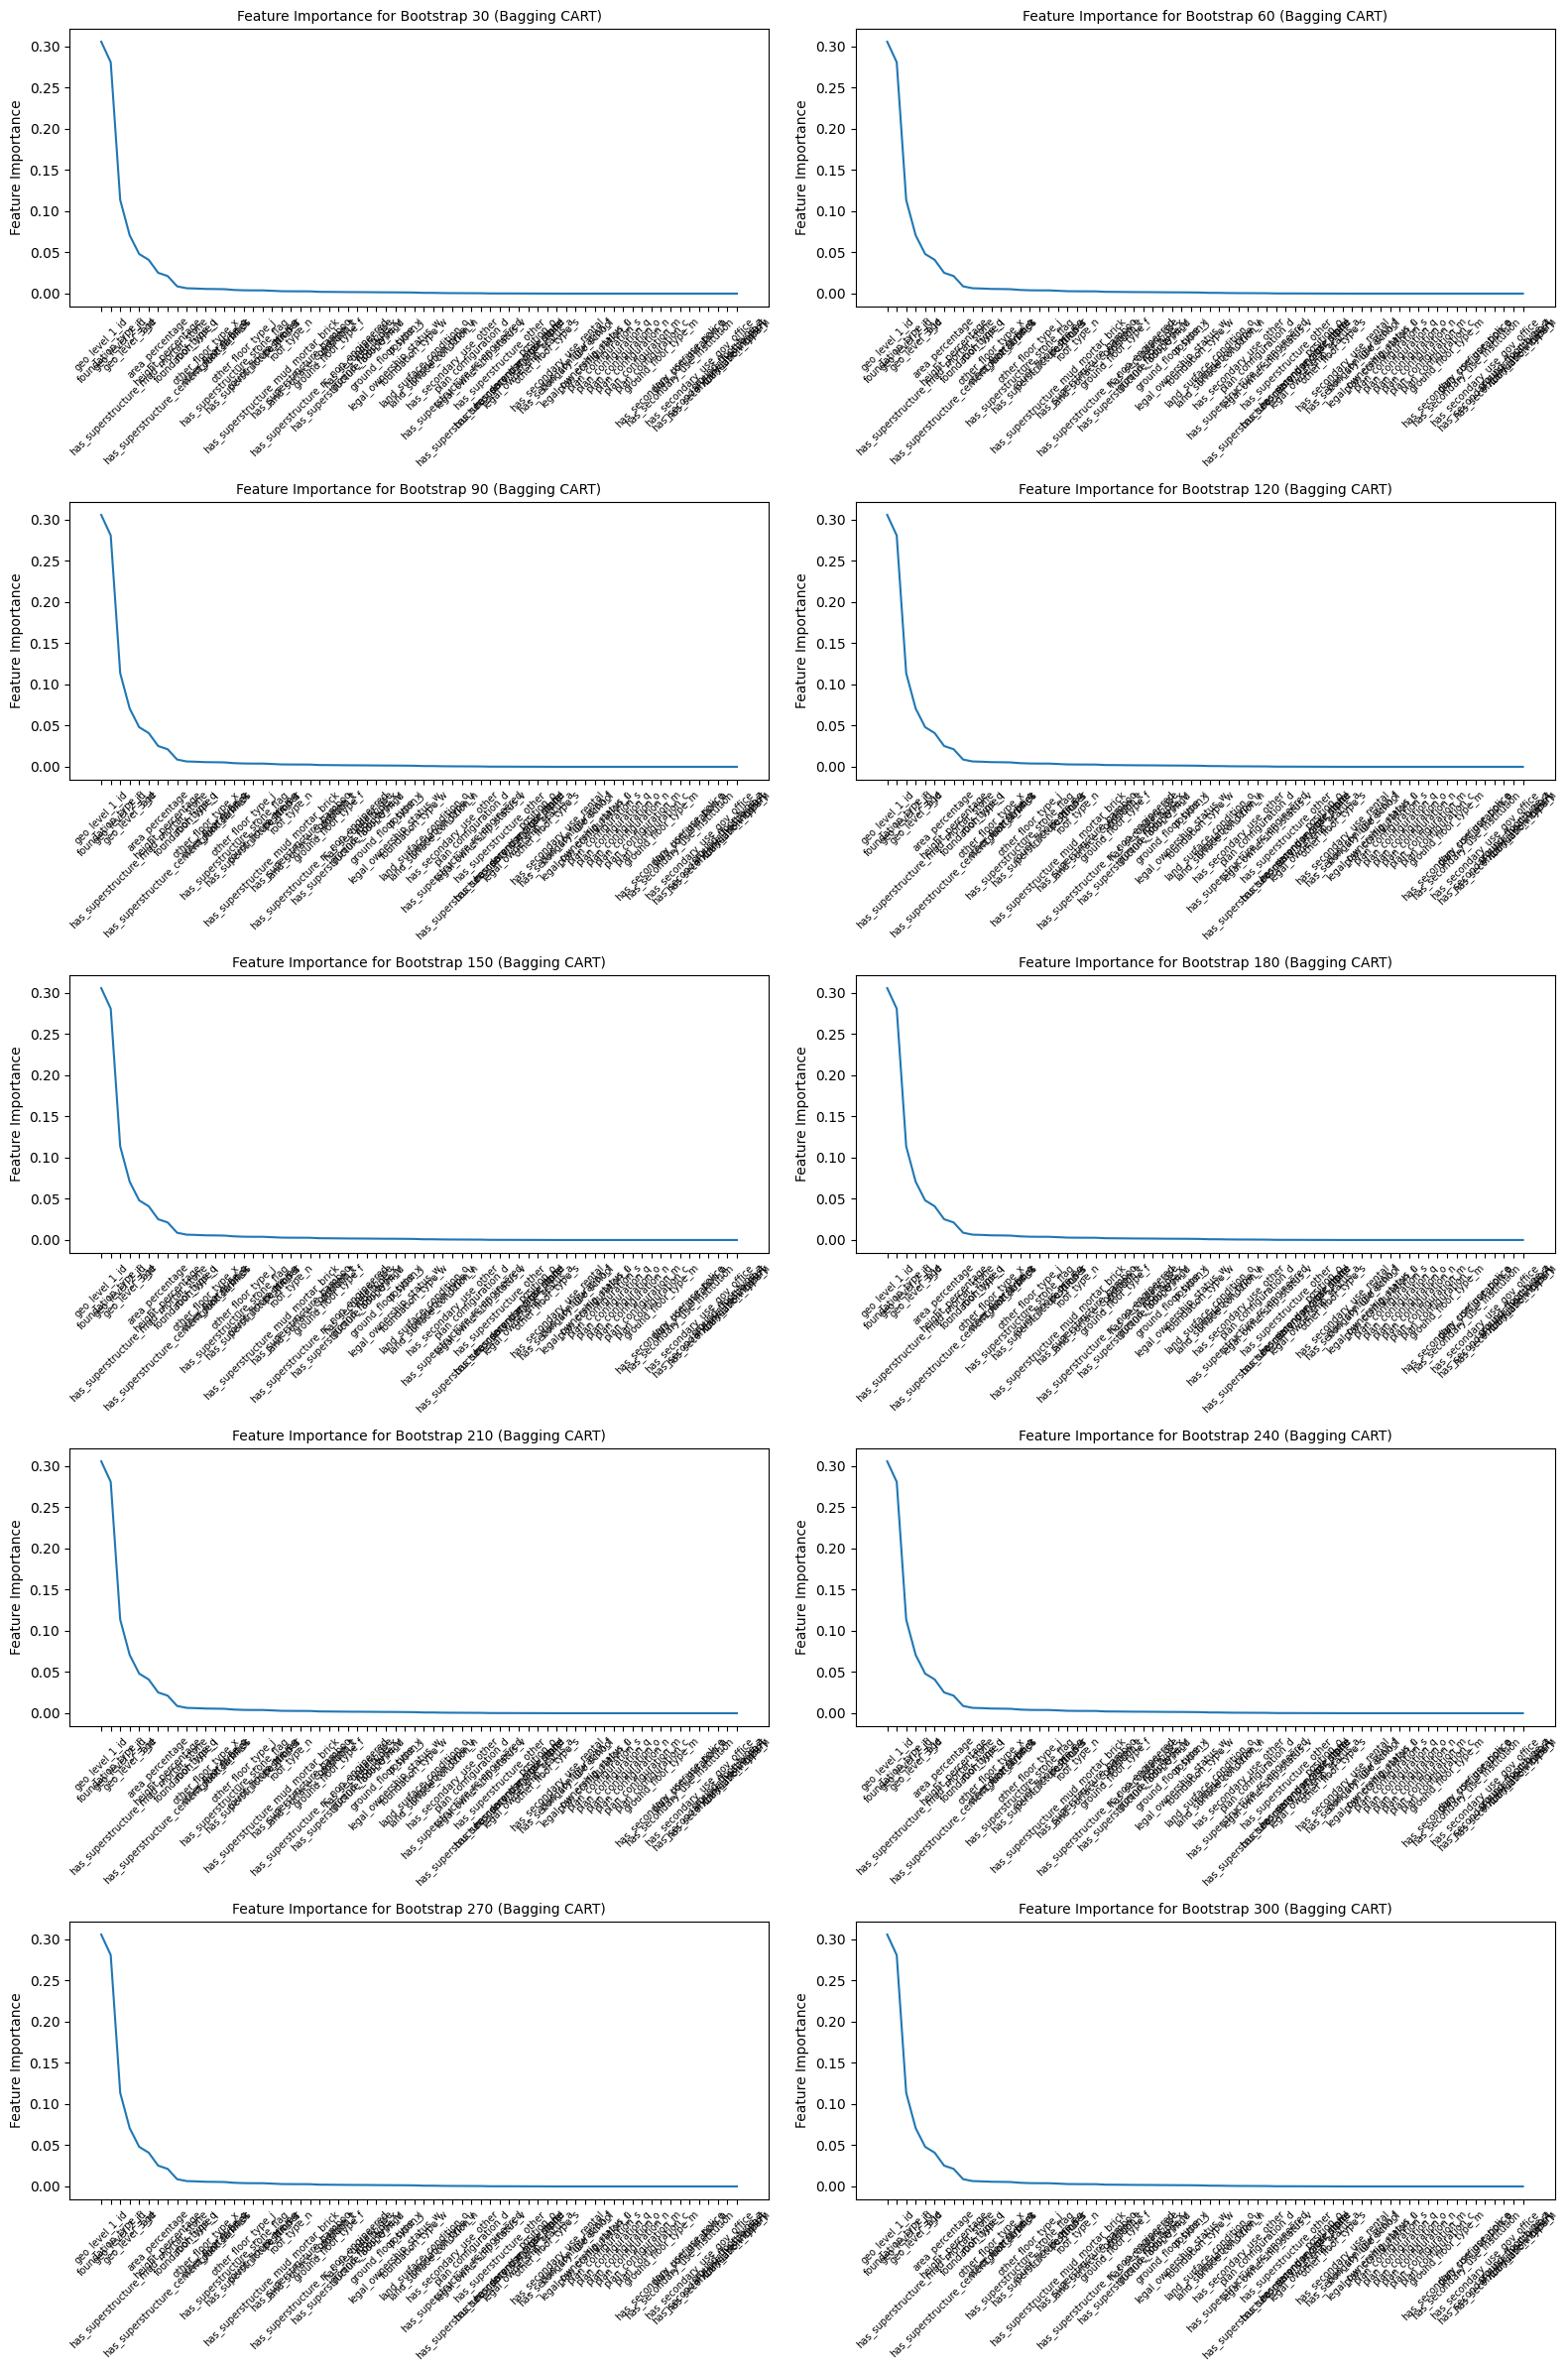

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the feature importances list to a NumPy array
feature_importances_bagging_cart = np.array(feature_importances_bagging_cart)

# Get the feature names from the DataFrame columns
feature_names = X.columns

# Calculate the number of rows and columns for subplot arrangement
num_plots = feature_importances_bagging_cart.shape[0]
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 24))

# Iterate over each bootstrap and create separate plots
for i, ax in enumerate(axes.flat):
    # Check if the current subplot is beyond the number of bootstraps
    if i >= num_plots:
        break

    # Sort the feature importances for the current bootstrap iteration
    sorted_indices = np.argsort(feature_importances_bagging_cart[i])[::-1]
    sorted_importances = feature_importances_bagging_cart[i][sorted_indices]

    # Plot the sorted feature importances
    ax.plot(range(len(sorted_importances)), sorted_importances)

    # Set the x-axis labels to variable names based on the sorted indices
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=45, fontsize=7)

    # Set the y-axis label
    ax.set_ylabel('Feature Importance')

    # Set the title
    ax.set_title(f'Feature Importance for Bootstrap {bootstrap_range[i]} (Bagging CART)', fontsize=10)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


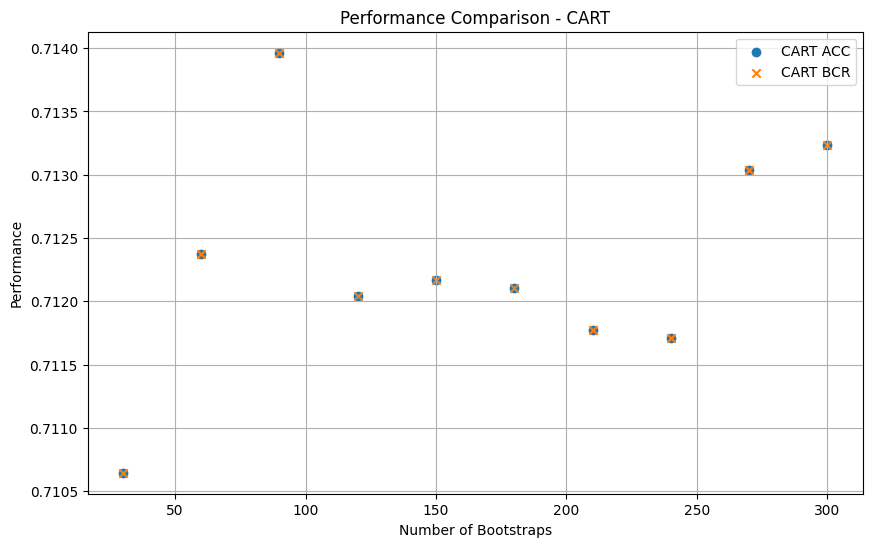

In [ ]:
import matplotlib.pyplot as plt

# Plot the ACC and BCR of CART
plt.figure(figsize=(10, 6))
plt.scatter(df_results_bagging_cart['Bootstraps'], df_results_bagging_cart['ACC'], label='CART ACC', marker='o')
plt.scatter(df_results_bagging_cart['Bootstraps'], df_results_bagging_cart['BCR'], label='CART BCR', marker='x')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Performance')
plt.title('Performance Comparison - CART')
plt.legend()
plt.grid(True)
plt.show()